# Quantum Kernel Machine Learning - Tutorial
## Quantum Kernel Classification on Real Hardware
This tutorial is based on a paper by Suzuki et. al., which itself is a study of the pioneering paper Supervised learning with quantum-enhanced feature spaces by Havlíček et.al. [1,2]. Suzuki et. al in their paper, study a two qubit classifier. The input data points are mapped to a unitary operator,
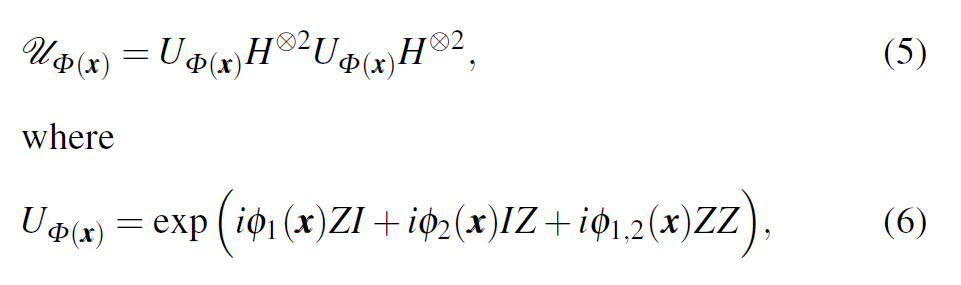
The input data is mapped to a unitary operator. U(x) is the unitary gate used to form the quantum circuit.The encoding functions are given as
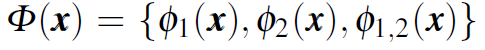
Encoding functions that transform the input data points to a higher dimensional feature space from Suzuki et. al. are
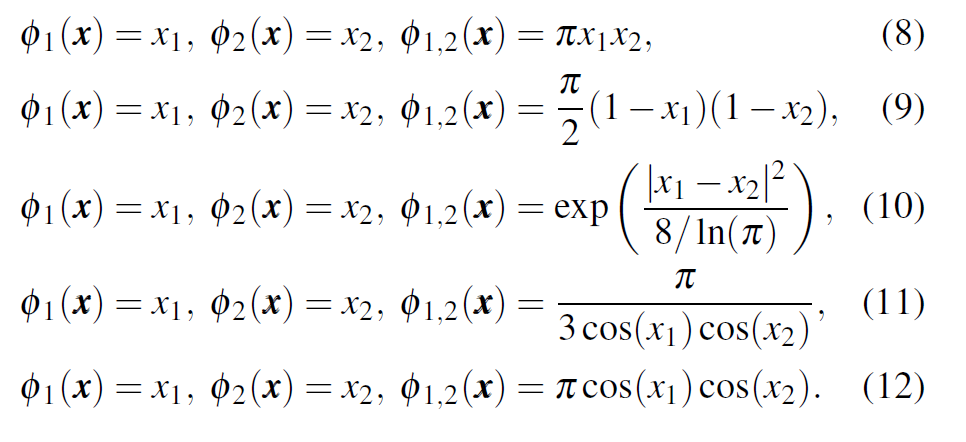

### Code

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()


In [2]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

### Imports

In [4]:
# Utilities
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import Optional, Callable, List, Union
from functools import reduce

# Qiskit imports 
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals

#Qiskit Machine Learning imports
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# seed for ramdomization, to keep outputs consistent
seed = 123456

### Encoding functions

In [5]:
def data_map_eq8(x: np.ndarray) -> float:
    """
    Define a function map from R^n to R.

    Args:
        x: data

    Returns:
        float: the mapped value
    """
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), x)
    return coeff

def data_map_eq9(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: (np.pi/2)*(m * n), 1 - x)
    return coeff

def data_map_eq10(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*np.exp(((n - m)*(n - m))/8), x)
    return coeff

def data_map_eq11(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: (np.pi/3)*(m * n), 1/(np.cos(x)))
    return coeff

def data_map_eq12(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), np.cos(x))
    return coeff

### Quantum Kernel

In [6]:
qfm_default = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full')
qfm_eq8 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq8)
qfm_eq9 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq9)
qfm_eq10 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq10)
qfm_eq11 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq11)
qfm_eq12 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq12)




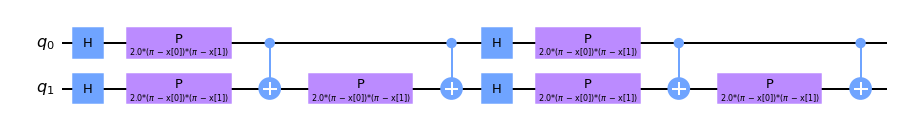

In [7]:
qfm_default.draw()

In [ ]:
qcomp_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

qkern_default = QuantumKernel(feature_map=qfm_default, quantum_instance=qcomp_backend)
qkern_eq8 = QuantumKernel(feature_map=qfm_eq8, quantum_instance=qcomp_backend)
qkern_eq9 = QuantumKernel(feature_map=qfm_eq9, quantum_instance=qcomp_backend)
qkern_eq10 = QuantumKernel(feature_map=qfm_eq10, quantum_instance=qcomp_backend)
qkern_eq11 = QuantumKernel(feature_map=qfm_eq11, quantum_instance=qcomp_backend)
qkern_eq12 = QuantumKernel(feature_map=qfm_eq12, quantum_instance=qcomp_backend)

In [8]:
real_qcomp_backend = QuantumInstance(provider.get_backend('ibmq_lima'), shots=32)

qkern_default = QuantumKernel(feature_map=qfm_default, quantum_instance=real_qcomp_backend)
qkern_eq8 = QuantumKernel(feature_map=qfm_eq8, quantum_instance=real_qcomp_backend)
qkern_eq9 = QuantumKernel(feature_map=qfm_eq9, quantum_instance=real_qcomp_backend)
qkern_eq10 = QuantumKernel(feature_map=qfm_eq10, quantum_instance=real_qcomp_backend)
qkern_eq11 = QuantumKernel(feature_map=qfm_eq11, quantum_instance=real_qcomp_backend)
qkern_eq12 = QuantumKernel(feature_map=qfm_eq12, quantum_instance=real_qcomp_backend)

### Experiment

Callable kernel classification test score for Linear SVM: 0.7916666666666666
Callable kernel classification test score for RBF SVM: 1.0
Callable kernel classification test score for QKernel_Default: 0.3333333333333333
Callable kernel classification test score for QKernel_Eq8: 0.4166666666666667
Callable kernel classification test score for QKernel_Eq9: 0.3333333333333333
Callable kernel classification test score for QKernel_Eq10: 0.5416666666666666
Callable kernel classification test score for QKernel_Eq11: 0.5416666666666666
Callable kernel classification test score for QKernel_Eq12: 0.5833333333333334
Callable kernel classification test score for Linear SVM: 0.4583333333333333
Callable kernel classification test score for RBF SVM: 1.0
Callable kernel classification test score for QKernel_Default: 0.5
Callable kernel classification test score for QKernel_Eq8: 0.5833333333333334
Callable kernel classification test score for QKernel_Eq9: 0.4166666666666667
Callable kernel classification

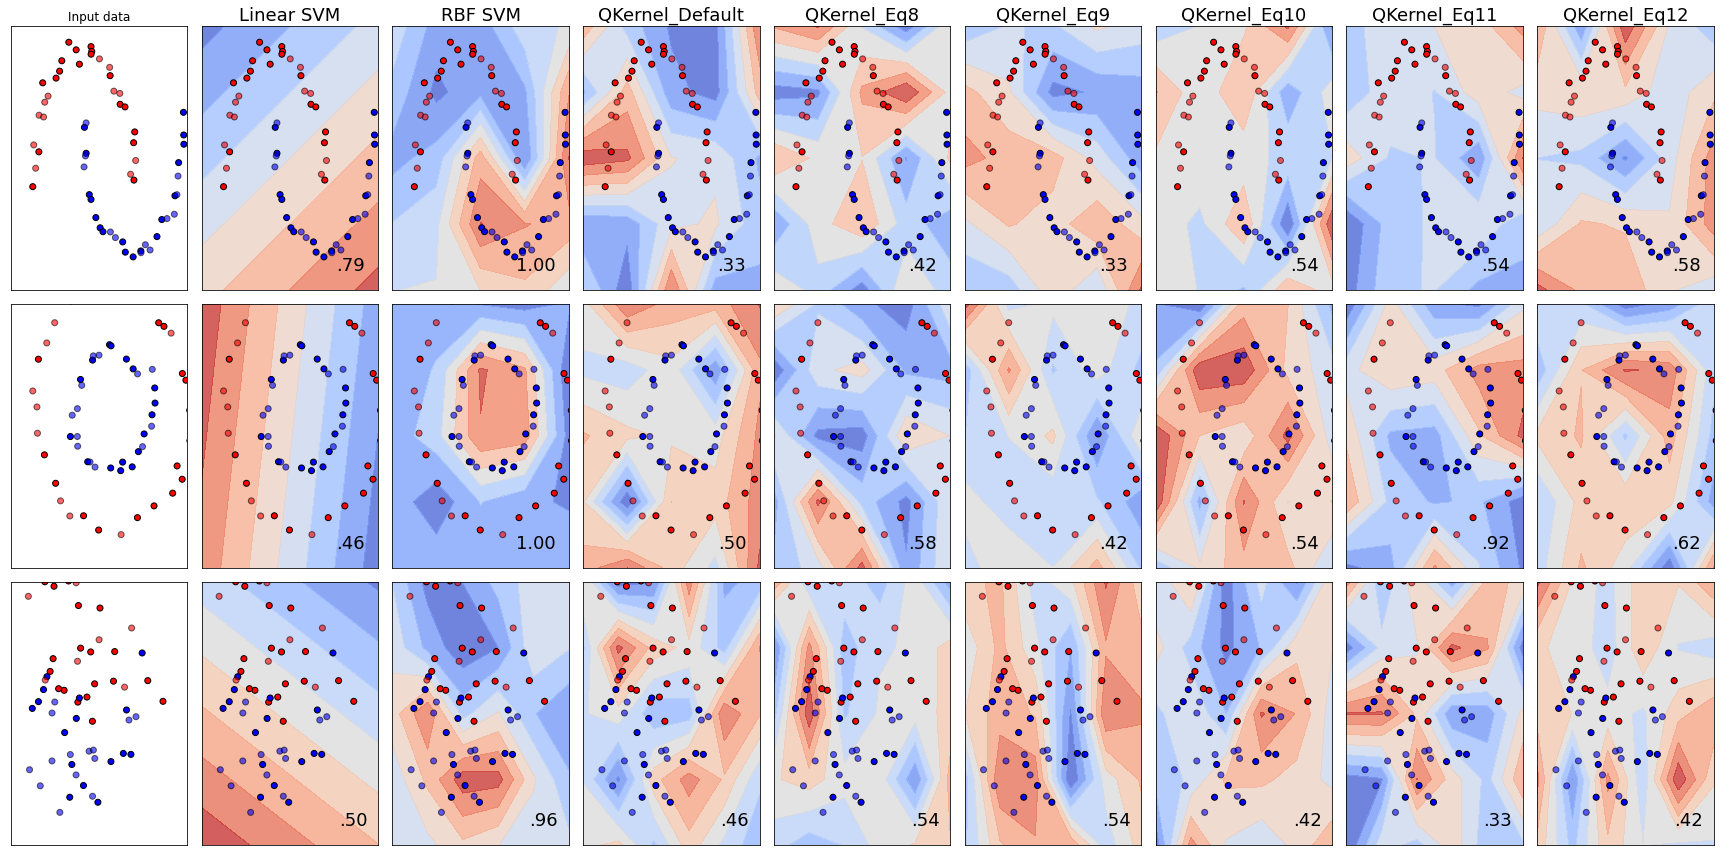

In [11]:
h = 1.0  # step size in the mesh

names = ["Linear SVM", "RBF SVM", "QKernel_Default", "QKernel_Eq8", "QKernel_Eq9", 
         "QKernel_Eq10", "QKernel_Eq11", "QKernel_Eq12"]
#names = ["Linear SVM", "RBF SVM", "QKernel_Default"]
classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(kernel=qkern_default.evaluate),
    SVC(kernel=qkern_eq8.evaluate),
    SVC(kernel=qkern_eq9.evaluate),
    SVC(kernel=qkern_eq10.evaluate),
    SVC(kernel=qkern_eq11.evaluate),
    SVC(kernel=qkern_eq12.evaluate),
              ]

X, y = make_classification(n_samples=60, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)


datasets = [make_moons(n_samples=60, noise=0.05, random_state=0),
            make_circles(n_samples=60, noise=0.05, factor=0.5, random_state=1),
            linearly_separable,
            ]

figure = plt.figure(figsize=(24, 12))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    #cm = plt.cm.RdBu
    cm = plt.cm.coolwarm
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print(f'Callable kernel classification test score for {name}: {score}')

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name,size=18)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=18, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
figure = plt.figure(figsize=(24, 12))
plt.tight_layout()
plt.show()